# Modelo de série temporal para prever as vendas mensais dos produtos
O objetivo do modelo é predizer a quantidade mensal de vendas de cada item utilizando os dados das notas fiscais, considerando as variáveis: código dos item, data de emissão da NF e a quantidade vendida. A quantidade vendida de cada item por mês é a variável resposta do modelo, já as variáveis regressoras foram construídas com base nas quantidades dos meses anteriores de cada observação para cada item. A estratégia utilizada foi criar variáveis que pudessem identificar os padrões passados de venda de cada item, para tanto, foram construídas variáveis de médias, dispersão, máximo, mínimo e tendência. O algoritmo utilizado foi o Random Forest e a avaliação do resultado do modelo foi realizada através do RMSE(Root Mean Square Error).

In [1]:
import os
os.getcwd()

'C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Importação dos dados

In [3]:
nf=pd.read_csv('nf_item_13_14.csv',sep=';')

In [4]:
nf.head()

,Nota_Fiscal,Item,Nat_Oper,Emissão,Quant
0,49318,0630/10,6102TO,2013-01-02,100.0
1,49318,0630/8,6102TO,2013-01-02,100.0
2,49318,0630/9,6102TO,2013-01-02,200.0
3,49318,0920/10,6102TO,2013-01-02,100.0
4,49318,0920/8,6102TO,2013-01-02,100.0


Ajuste da variável Emissão

In [5]:
nf['Emissão']=pd.to_datetime(nf['Emissão'],infer_datetime_format=True)

In [6]:
nf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179795 entries, 0 to 179794
Data columns (total 5 columns):
Nota_Fiscal    179795 non-null int64
Item           179795 non-null object
Nat_Oper       179795 non-null object
Emissão        179795 non-null datetime64[ns]
Quant          179795 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 6.9+ MB


Sumarização dos itens por emissão. Soma das quantidades de cada item por data de emissão.

In [7]:
nf=nf.groupby(['Item','Emissão'],as_index=False).agg({'Quant':'sum'})

In [8]:
nf.head()

,Item,Emissão,Quant
0,01050/10,2014-11-03,20.0
1,01050/7,2014-05-05,10.0
2,01050/7,2014-11-03,20.0
3,01050/8,2014-04-15,10.0
4,01050/8,2014-05-05,10.0


Supressão dos itens com vendas inferiores a um mil unidades durante o período de 24 meses.

In [9]:
sum_item=nf.groupby(['Item'],as_index=False).agg({'Quant':'sum'})

In [10]:
itens_sel=sum_item['Item'][sum_item['Quant']>1000]
itens_sel.head()

4      0126/10
5       0126/9
6    0340/3-GD
7    0340/4-GD
8    0340/4-PQ
Name: Item, dtype: object

In [11]:
nf_2=nf[nf['Item'].isin(itens_sel)]

In [12]:
nf_2.head()

,Item,Emissão,Quant
11,0126/10,2013-02-07,10.0
12,0126/10,2013-02-15,10.0
13,0126/10,2013-03-26,10.0
14,0126/10,2013-05-17,50.0
15,0126/10,2013-08-05,10.0


Extração do mês da data

In [13]:
nf_2['Mês']=nf_2['Emissão'].dt.month

Extração do ano da data

In [14]:
nf_2['Ano']=nf_2['Emissão'].dt.year

In [15]:
nf_2.head()

,Item,Emissão,Quant,Mês,Ano
11,0126/10,2013-02-07,10.0,2,2013
12,0126/10,2013-02-15,10.0,2,2013
13,0126/10,2013-03-26,10.0,3,2013
14,0126/10,2013-05-17,50.0,5,2013
15,0126/10,2013-08-05,10.0,8,2013


Transformação dos meses de 1 a 12 do período de dois anos para 1 a 24 meses.

In [16]:
l=[]
for index,row in nf_2.iterrows():
    if row['Ano']==2014:
        m=row['Mês']+12
        l.append(m)
    else:
        l.append(row['Mês'])
nf_2['Mês_2']=l

In [17]:
nf_2.tail()

,Item,Emissão,Quant,Mês,Ano,Mês_2
49117,MS297458,2014-12-09,22.0,12,2014,24
49118,MS297458,2014-12-15,50.0,12,2014,24
49119,MS297458,2014-12-17,10.0,12,2014,24
49120,MS297458,2014-12-18,50.0,12,2014,24
49121,MS297458,2014-12-19,35.0,12,2014,24


Sumarização dos itens por Mês_2. Soma das quantidades de cada item por mês de 1 a 24.

In [18]:
nf_3=nf_2.groupby(['Item','Mês_2'],as_index=False).agg({'Quant':'sum'})

In [19]:
nf_3.head()

,Item,Mês_2,Quant
0,0126/10,2,20.0
1,0126/10,3,10.0
2,0126/10,5,50.0
3,0126/10,8,10.0
4,0126/10,10,120.0


Cálculo da média dos meses anteriores. O objetivo foi calcular a média das observações de cada item do período entre o primeiro mês do dataset e o mês anterior ao de destino do cálculo.

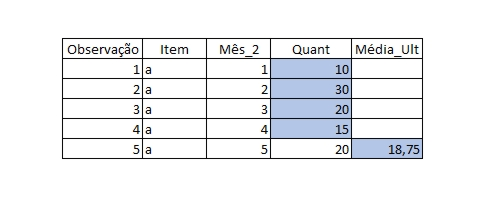

In [20]:
from IPython.display import Image
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\media.jpg")

In [21]:
l=list(nf_3['Item'].unique())
l_m=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    for index,row in df_item.iterrows():
        if index==0:
            m=0
        else:
            df_item_2=df_item[df_item['Mês_2']<row['Mês_2']]
            for j in df_item_2['Quant']:
                m=df_item_2['Quant'].mean()
        l_m.append(m)
nf_3['Média_Ult']=l_m

In [22]:
nf_3.head()

,Item,Mês_2,Quant,Média_Ult
0,0126/10,2,20.0,0.000000
1,0126/10,3,10.0,20.000000
2,0126/10,5,50.0,15.000000
3,0126/10,8,10.0,26.666667
4,0126/10,10,120.0,22.500000


Cálculo da mediana dos meses anteriores.

In [23]:
l=list(nf_3['Item'].unique())
l_m=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    for index,row in df_item.iterrows():
        if index==0:
            m=0
        else:
            df_item_2=df_item[df_item['Mês_2']<row['Mês_2']]
            for j in df_item_2['Quant']:
                m=df_item_2['Quant'].median()
        l_m.append(m)
nf_3['Mediana_Ult']=l_m

In [24]:
nf_3.head()

,Item,Mês_2,Quant,Média_Ult,Mediana_Ult
0,0126/10,2,20.0,0.000000,0.0
1,0126/10,3,10.0,20.000000,20.0
2,0126/10,5,50.0,15.000000,15.0
3,0126/10,8,10.0,26.666667,20.0
4,0126/10,10,120.0,22.500000,15.0


Cálculo do valor mínimo dos meses anteriores.

In [25]:
l=list(nf_3['Item'].unique())
l_m=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    for index,row in df_item.iterrows():
        if index==0:
            m=0
        else:
            df_item_2=df_item[df_item['Mês_2']<row['Mês_2']]
            for j in df_item_2['Quant']:
                m=df_item_2['Quant'].min()
        l_m.append(m)
nf_3['Min_Ult']=l_m

In [26]:
nf_3.head()

,Item,Mês_2,Quant,Média_Ult,Mediana_Ult,Min_Ult
0,0126/10,2,20.0,0.000000,0.0,0.0
1,0126/10,3,10.0,20.000000,20.0,20.0
2,0126/10,5,50.0,15.000000,15.0,10.0
3,0126/10,8,10.0,26.666667,20.0,10.0
4,0126/10,10,120.0,22.500000,15.0,10.0


Cálculo do valor máximo dos meses anteriores.

In [27]:
l=list(nf_3['Item'].unique())
l_m=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    for index,row in df_item.iterrows():
        if index==0:
            m=0
        else:
            df_item_2=df_item[df_item['Mês_2']<row['Mês_2']]
            for j in df_item_2['Quant']:
                m=df_item_2['Quant'].max()
        l_m.append(m)
nf_3['Max_Ult']=l_m

In [28]:
nf_3.head()

,Item,Mês_2,Quant,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult
0,0126/10,2,20.0,0.000000,0.0,0.0,0.0
1,0126/10,3,10.0,20.000000,20.0,20.0,20.0
2,0126/10,5,50.0,15.000000,15.0,10.0,20.0
3,0126/10,8,10.0,26.666667,20.0,10.0,50.0
4,0126/10,10,120.0,22.500000,15.0,10.0,50.0


Cálculo do desvio padrão dos meses anteriores.

In [29]:
l=list(nf_3['Item'].unique())
l_m=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    for index,row in df_item.iterrows():
        if index==0 or index==1:
            m=0
        else:
            df_item_2=df_item[df_item['Mês_2']<row['Mês_2']]
            for j in df_item_2['Quant']:
                m=df_item_2['Quant'].std()
        l_m.append(m)
nf_3['Desv_Ult']=l_m

In [30]:
nf_3.head()

,Item,Mês_2,Quant,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult
0,0126/10,2,20.0,0.000000,0.0,0.0,0.0,0.000000
1,0126/10,3,10.0,20.000000,20.0,20.0,20.0,0.000000
2,0126/10,5,50.0,15.000000,15.0,10.0,20.0,7.071068
3,0126/10,8,10.0,26.666667,20.0,10.0,50.0,20.816660
4,0126/10,10,120.0,22.500000,15.0,10.0,50.0,18.929694


Criação da variável com o valor da quantidade do mês anterior(-1). 

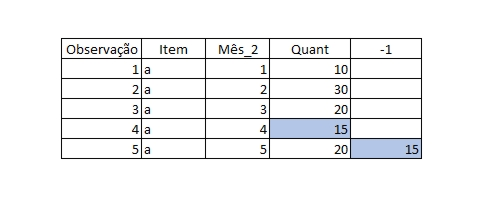

In [31]:
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\\anterior_1.jpg")

In [32]:
l=list(nf_3['Item'].unique())
l_l=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    q_df_item=list(df_item.Quant)
    q_df_shift=list(df_item.Quant.shift(1))
    q_df_shift[0]=0
    l_l+=q_df_shift
nf_3['-1']=l_l

In [33]:
nf_3.head()

,Item,Mês_2,Quant,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1
0,0126/10,2,20.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0126/10,3,10.0,20.000000,20.0,20.0,20.0,0.000000,20.0
2,0126/10,5,50.0,15.000000,15.0,10.0,20.0,7.071068,10.0
3,0126/10,8,10.0,26.666667,20.0,10.0,50.0,20.816660,50.0
4,0126/10,10,120.0,22.500000,15.0,10.0,50.0,18.929694,10.0


Criação da variável com o valor da quantidade do segundo mês anterior. 

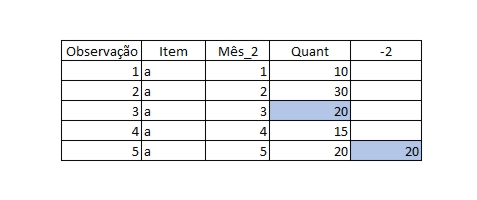

In [34]:
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\\anterior_2.jpg")

In [35]:
l=list(nf_3['Item'].unique())
l_l=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    q_df_item=list(df_item.Quant)
    if len(q_df_item)>=3:
        q_df_shift=list(df_item.Quant.shift(2))
        q_df_shift[0]=0
        q_df_shift[1]=0
    elif len(q_df_item)==2:
        q_df_shift=[0,0]
    else:
        q_df_shift=[0]
    l_l+=q_df_shift
nf_3['-2']=l_l

In [36]:
nf_3.head()

,Item,Mês_2,Quant,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2
0,0126/10,2,20.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0126/10,3,10.0,20.000000,20.0,20.0,20.0,0.000000,20.0,0.0
2,0126/10,5,50.0,15.000000,15.0,10.0,20.0,7.071068,10.0,20.0
3,0126/10,8,10.0,26.666667,20.0,10.0,50.0,20.816660,50.0,10.0
4,0126/10,10,120.0,22.500000,15.0,10.0,50.0,18.929694,10.0,50.0


Criação da variável com o valor da quantidade do terceiro mês anterior.

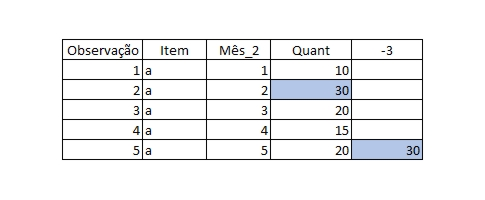

In [37]:
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\\anterior_3.jpg")

In [38]:
l=list(nf_3['Item'].unique())
l_l=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    q_df_item=list(df_item.Quant)
    if len(q_df_item)>=4:
        q_df_shift=list(df_item.Quant.shift(3))
        q_df_shift[0]=0
        q_df_shift[1]=0
        q_df_shift[2]=0
    elif len(q_df_item)==3:
        q_df_shift=[0,0,0]
    elif len(q_df_item)==2:
        q_df_shift=[0,0]
    else:
        q_df_shift=[0]
    l_l+=q_df_shift
nf_3['-3']=l_l

In [39]:
nf_3.head()

,Item,Mês_2,Quant,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3
0,0126/10,2,20.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0126/10,3,10.0,20.000000,20.0,20.0,20.0,0.000000,20.0,0.0,0.0
2,0126/10,5,50.0,15.000000,15.0,10.0,20.0,7.071068,10.0,20.0,0.0
3,0126/10,8,10.0,26.666667,20.0,10.0,50.0,20.816660,50.0,10.0,20.0
4,0126/10,10,120.0,22.500000,15.0,10.0,50.0,18.929694,10.0,50.0,10.0


Criação da variável com o valor da diferença entre as duas quantidades dos meses anteriores.

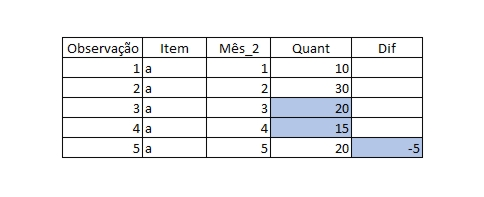

In [40]:
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\\dif.jpg")

In [41]:
l=list(nf_3['Item'].unique())
l_d=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    q_df_shift_1=list(df_item.Quant.shift(1))
    q_df_shift_2=list(df_item.Quant.shift(2))
    zip_object=zip(q_df_shift_1, q_df_shift_2)
    diff=[]
    for q_df_shift_1_i, q_df_shift_2_i in zip_object:
        diff.append(q_df_shift_1_i-q_df_shift_2_i)
    l_d+=diff
nf_3['Dif']=l_d
nf_3['Dif']=nf_3['Dif'].fillna(0)

Criação da variável com o valor da média móvel das últimos seis meses.

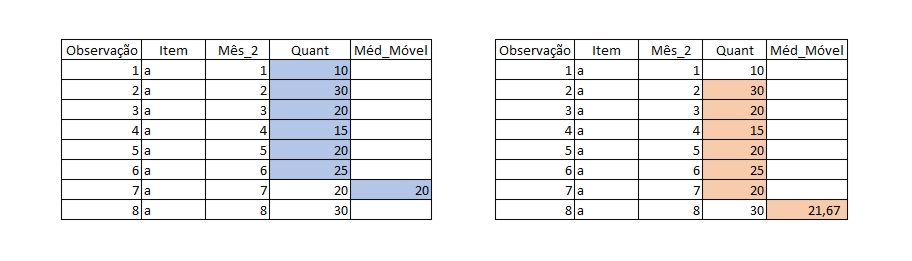

In [42]:
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\\movel.jpg")

In [43]:
l=list(nf_3['Item'].unique())
l_m=[]
for i in l:
    df_item=nf_3[nf_3['Item']==i]
    df_item=df_item.reset_index()
    
    for index,row in df_item.iterrows():
        if index==0:
            m=0
        else:
            df_item_2=df_item[df_item['Mês_2']<row['Mês_2']]
            for j in df_item_2['Quant']:
                m=df_item_2['Quant'].tail(6).mean()
        l_m.append(m)
nf_3['Méd_Móvel']=l_m

In [44]:
nf_3.head()

,Item,Mês_2,Quant,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3,Dif,Méd_Móvel
0,0126/10,2,20.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0126/10,3,10.0,20.000000,20.0,20.0,20.0,0.000000,20.0,0.0,0.0,0.0,20.000000
2,0126/10,5,50.0,15.000000,15.0,10.0,20.0,7.071068,10.0,20.0,0.0,-10.0,15.000000
3,0126/10,8,10.0,26.666667,20.0,10.0,50.0,20.816660,50.0,10.0,20.0,40.0,26.666667
4,0126/10,10,120.0,22.500000,15.0,10.0,50.0,18.929694,10.0,50.0,10.0,-40.0,22.500000


Criação das variáveis coeficientes linear e angular da reta ajustada a série de dados. O objetivo de calcular esses coeficientes foi tentar captar a tendência da série.

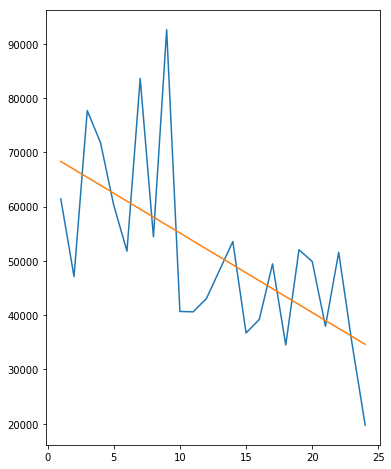

coeficiente angular: -1465.5516941461217
coeficiente linear: 69806.27548782334
equação da reta: 69806.27548782334 + -1465.5516941461217*X


In [45]:
item_sel=nf_3[(nf_3['Item']=='0620/9')]
y=item_sel['Quant'].values
x=list(item_sel['Mês_2'])
X=np.linspace(x[0],x[-1])
Y=(np.poly1d(np.polyfit(x, y, 1))[1])*X+np.poly1d(np.polyfit(x, y, 1))[0]

plt.figure(figsize=(6,8))
plt.plot(x,y)
plt.plot(X,Y)
plt.show()

print('coeficiente angular:'+' '+str(np.poly1d(np.polyfit(x, y, 1))[1]))
print('coeficiente linear:'+' '+str(np.poly1d(np.polyfit(x, y, 1))[0]))
print('equação da reta:'+' '+str(np.poly1d(np.polyfit(x, y, 1))[0])+' '+'+'+' '+str(np.poly1d(np.polyfit(x, y, 1))[1])+'*X')

In [46]:
l=list(nf_3['Item'].unique())
coef_dic={'Item':[],'Coef_Ang':[],'Coef_Lin':[]}
for i in l:
    df=nf_3[nf_3['Item']==i]
    df=df.reset_index()
    for index,row in df.iterrows():
        df_2=df[df['Mês_2']<row['Mês_2']]
    
        month=[]
        for k in range(len(df_2)-1):
            j=(df_2['Mês_2'][k+1]-df_2['Mês_2'][0])
            month.append(j)
        x=month
        x.insert(0,0)
        y=df_2['Quant']
        y1=list(df_2['Quant'])
        if len(df)>1:
            try:
                coef=np.polyfit(x, y, 1)
            except:
                coef=[]
                try:
                    ang=(y1[-1] - y1[0])/(x[-1] - x[0])
                except:
                    ang=0
                if ang != 0:
                    lin=(sum(y1)/len(y1))-(ang*(sum(x)/len(x)))
                else:
                    lin=0
                coef.append(ang)
                coef.append(lin)
        else:
            coef=[0,0]
        coef_dic['Item'].append(i)
        coef_dic['Coef_Ang'].append(coef[0])
        coef_dic['Coef_Lin'].append(coef[1])
    coef_df=pd.DataFrame(coef_dic)

In [47]:
coef_df=pd.DataFrame(coef_dic)

In [48]:
coef_df.tail()

,Item,Coef_Ang,Coef_Lin
4671,MS297458,-58.000000,232.000000
4672,MS297458,18.000000,206.666667
4673,MS297458,1.300000,217.800000
4674,MS297458,2.700000,216.400000
4675,MS297458,-7.285714,229.714286


Junção dos coeficientes linear e angular as outras variáveis.

In [49]:
nf_4=pd.concat([nf_3,coef_df],axis=1)

In [50]:
nf_4.head()

,Item,Mês_2,Quant,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3,Dif,Méd_Móvel,Item,Coef_Ang,Coef_Lin
0,0126/10,2,20.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0126/10,0.000000,0.000000
1,0126/10,3,10.0,20.000000,20.0,20.0,20.0,0.000000,20.0,0.0,0.0,0.0,20.000000,0126/10,0.000000,0.000000
2,0126/10,5,50.0,15.000000,15.0,10.0,20.0,7.071068,10.0,20.0,0.0,-10.0,15.000000,0126/10,-10.000000,20.000000
3,0126/10,8,10.0,26.666667,20.0,10.0,50.0,20.816660,50.0,10.0,20.0,40.0,26.666667,0126/10,11.428571,11.428571
4,0126/10,10,120.0,22.500000,15.0,10.0,50.0,18.929694,10.0,50.0,10.0,-40.0,22.500000,0126/10,-0.238095,23.095238


In [51]:
nf_4=nf_4.loc[:,~nf_4.columns.duplicated()]

In [52]:
nf_4.head()

,Item,Mês_2,Quant,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3,Dif,Méd_Móvel,Coef_Ang,Coef_Lin
0,0126/10,2,20.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0126/10,3,10.0,20.000000,20.0,20.0,20.0,0.000000,20.0,0.0,0.0,0.0,20.000000,0.000000,0.000000
2,0126/10,5,50.0,15.000000,15.0,10.0,20.0,7.071068,10.0,20.0,0.0,-10.0,15.000000,-10.000000,20.000000
3,0126/10,8,10.0,26.666667,20.0,10.0,50.0,20.816660,50.0,10.0,20.0,40.0,26.666667,11.428571,11.428571
4,0126/10,10,120.0,22.500000,15.0,10.0,50.0,18.929694,10.0,50.0,10.0,-40.0,22.500000,-0.238095,23.095238


Verificação de missing values.

In [53]:
pd.isnull(nf_4).sum()

Item           0
Mês_2          0
Quant          0
Média_Ult      0
Mediana_Ult    0
Min_Ult        0
Max_Ult        0
Desv_Ult       0
-1             0
-2             0
-3             0
Dif            0
Méd_Móvel      0
Coef_Ang       0
Coef_Lin       0
dtype: int64

Ordenação dos dados pelo mês.

In [54]:
nf_4=nf_4.sort_values(by='Mês_2')

Criação de um novo índice com base na variável Mês_2.

In [55]:
nf_4=nf_4.reset_index(drop=True)

In [56]:
nf_4.head()

,Item,Mês_2,Quant,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3,Dif,Méd_Móvel,Coef_Ang,Coef_Lin
0,0688/10,1,2324.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101A/9,1,32881.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101A/9-LO,1,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101L/9,1,3070.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M0642/8,1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Seleção das variáveis regressoras.

In [57]:
x = nf_4.drop(['Item','Mês_2','Quant','Coef_Lin'], axis = 1)

In [58]:
x.head()

,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3,Dif,Méd_Móvel,Coef_Ang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Seleção da variável resposta.

In [59]:
y=nf_4.Quant

In [60]:
y.head()

0     2324.0
1    32881.0
2     1000.0
3     3070.0
4       10.0
Name: Quant, dtype: float64

Divisão do banco em treino e teste. A estratégia foi dividir o banco original na proporção de 70% para treino e 30% para o teste final, contudo o banco de treino foi dividido novamente em três bancos de treino e validação, utilizando a técnica kfold, a fim de treinar o modelo e selecionar os melhores parâmetros. No final do treino, o modelo foi avaliado utilizando o banco teste. Por se tratar de uma série temporal, a divisão entre treino e teste não foi realizada de forma aleatória, foi respeitdada a temporalidade dos dados.

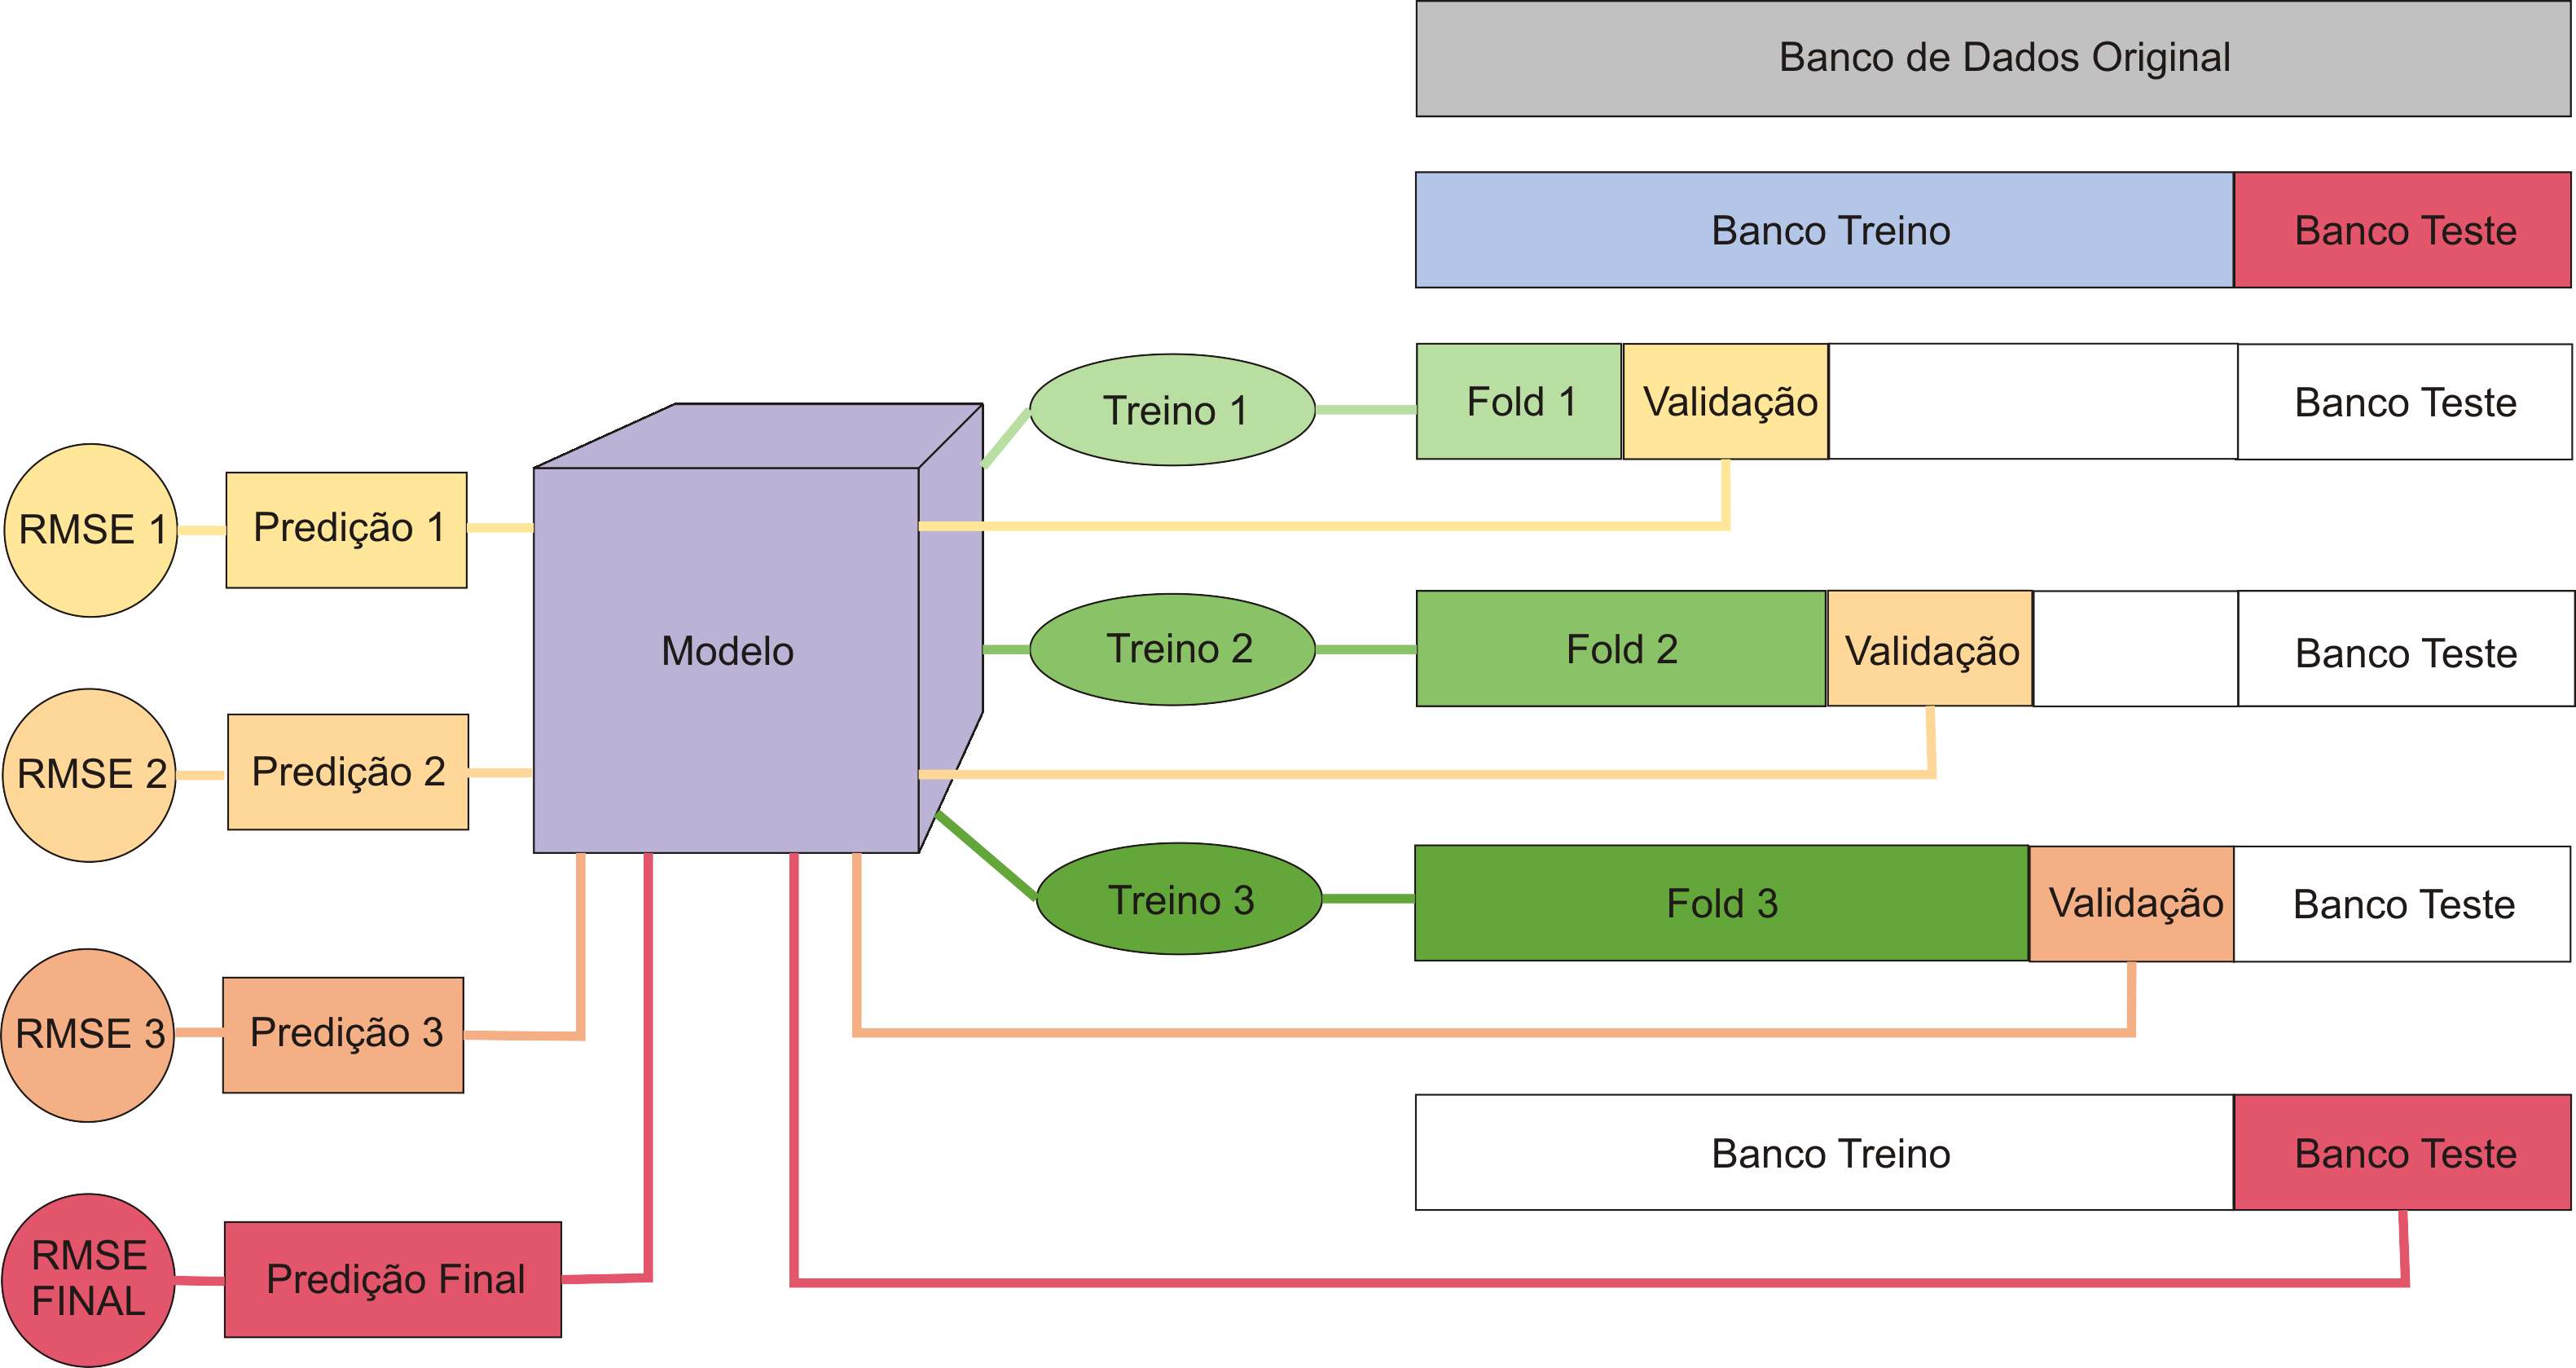

In [61]:
Image("C:\\Users\\user\\Documents\\Fabio\\Projetos_ML\\Serie_temporal\kfold.png")

In [62]:
lim=round(len(x)*0.7)

In [63]:
print(lim)

3273


In [64]:
train_x=x.loc[0:lim]

In [65]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3274 entries, 0 to 3273
Data columns (total 11 columns):
Média_Ult      3274 non-null float64
Mediana_Ult    3274 non-null float64
Min_Ult        3274 non-null float64
Max_Ult        3274 non-null float64
Desv_Ult       3274 non-null float64
-1             3274 non-null float64
-2             3274 non-null float64
-3             3274 non-null float64
Dif            3274 non-null float64
Méd_Móvel      3274 non-null float64
Coef_Ang       3274 non-null float64
dtypes: float64(11)
memory usage: 281.4 KB


In [66]:
train_y=y.loc[0:lim]

In [67]:
test_x=x.loc[lim+1:]

In [68]:
test_y=y.loc[lim+1:]

In [69]:
train_x.tail()

,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3,Dif,Méd_Móvel,Coef_Ang
3269,2021.6250,1655.0,700.0,4347.0,1064.649794,1660.0,2069.0,3630.0,-409.0,1731.500000,-16.126598
3270,89810.1250,88508.5,59226.0,119612.0,19398.116417,101254.0,75100.0,74492.0,26154.0,73941.500000,-2078.072890
3271,7056.9375,5997.5,2116.0,14650.0,3100.453934,4727.0,4124.0,9819.0,603.0,8185.000000,162.093990
3272,3888.5000,3968.5,579.0,6171.0,1586.911928,4253.0,6171.0,4076.0,-1918.0,3963.166667,28.434783
3273,1388.1250,1305.0,230.0,3070.0,736.787792,910.0,230.0,450.0,680.0,1075.000000,-81.144501


In [70]:
test_x.head()

,Média_Ult,Mediana_Ult,Min_Ult,Max_Ult,Desv_Ult,-1,-2,-3,Dif,Méd_Móvel,Coef_Ang
3274,277.692308,200.0,10.0,930.0,291.266025,200.0,200.0,930.0,0.0,280.000000,8.682808
3275,705.250000,682.5,161.0,1298.0,264.634213,456.0,681.0,1298.0,-225.0,770.500000,-6.560102
3276,4910.437500,4273.0,2350.0,8440.0,1824.493244,8440.0,4256.0,4268.0,4184.0,4795.500000,57.237212
3277,47516.875000,44868.0,29310.0,66470.0,10859.229597,37739.0,43560.0,44976.0,-5821.0,37975.833333,-1104.648338
3278,8220.000000,8220.0,7810.0,8630.0,579.827561,7810.0,8630.0,0.0,-820.0,8220.000000,-273.333333


In [75]:
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor

In [72]:
from sklearn.metrics import mean_squared_error

## Modelo Kfold para time series

In [73]:
param_grid = {'n_estimators':[1000,1500,2000,2500],'max_features':['auto','sqrt','log2'],'max_depth':[10,20,30,40,50],
              'min_samples_split':[2,5,10,15,20],'min_samples_leaf':[1,2,5,10,15],'bootstrap':[True,False]}   

In [74]:
from sklearn.model_selection import RandomizedSearchCV

In [76]:
rf=RandomForestRegressor()

In [77]:
gs = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_jobs=-1, scoring="neg_mean_squared_error", 
                         verbose=10, n_iter=3)

In [78]:
X_train_kf=train_x.values
y_train_kf=train_y

In [79]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(3)
score_list=[]
for train_index, test_index in tscv.split(X_train_kf):
    X_train, X_test = X_train_kf[train_index], X_train_kf[test_index]
    y_train, y_test = y_train_kf[train_index], y_train_kf[test_index]
    gs.fit(X_train,y_train)
    y_pred = gs.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test,y_pred))
    score_list.append(score)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   15.6s remaining:   54.9s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   17.4s remaining:   34.8s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   20.9s remaining:   26.2s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   22.4s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   24.0s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   29.7s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   30.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   30.4s finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   10.9s remaining:   38.3s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   11.9s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   12.8s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   13.1s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   14.7s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   16.8s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   18.4s finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   17.9s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   20.6s remaining:   41.4s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   23.5s remaining:   29.4s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   26.5s remaining:   21.2s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   26.5s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   28.7s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   30.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   30.4s finished


In [80]:
np.mean(score_list)

9022.259950940503

In [81]:
pred_final=gs.predict(test_x)

In [83]:
mse=sum((pred_final-test_y)**2)/len(pred_final)

In [84]:
rmse=np.sqrt(mse)
print(rmse)

7852.729924842164
